 **Time Series Analysis**

it's analysis of data which collected on certain time interval, it's very common form of data for example stock market data, daily sales data, home energy usage etc.here i am trying to do analysis of time series data

This analysis have 4 phases:

1. Load data

2. Check stationarity

3. Make series stationary

4. Buid model

**1. Load data**

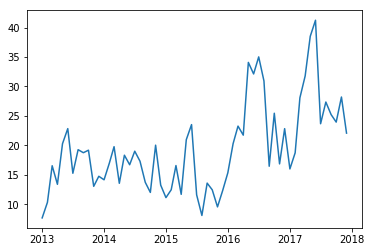

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('Retail.csv')

data['YearMonth'] = pd.to_datetime(data['YearMonth'],format="%Y%m")
data = data.sort_values(by = 'YearMonth')
data = data.set_index('YearMonth')
ts = data['Volume']

plt.plot(ts)
plt.show()

**2. Check Stationarity**

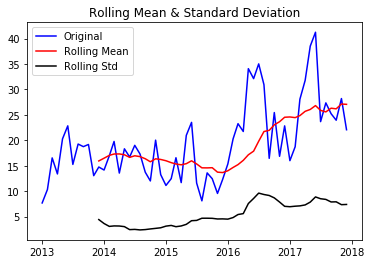

Results of Dickey-Fuller Test:
Test Statistic                 -3.422202
p-value                         0.010225
#Lags Used                      0.000000
Number of Observations Used    59.000000
dtype: float64
None


In [6]:
from statsmodels.tsa.stattools import adfuller

def st_check(timeseries):   
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std  = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print (dfoutput)
    
print(st_check(ts))

**3. Make series stationary**

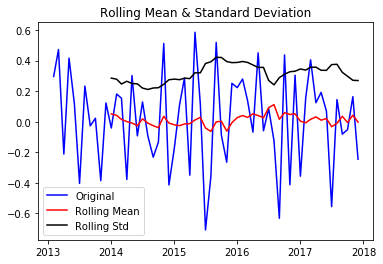

Results of Dickey-Fuller Test:
Test Statistic                -7.619334e+00
p-value                        2.149246e-11
#Lags Used                     1.000000e+00
Number of Observations Used    5.700000e+01
dtype: float64
None


In [8]:
ts_log=np.log(ts)
ts_log_dif = ts_log - ts_log.shift()
ts_log_dif.dropna(inplace=True)
print(st_check(ts_log_dif))

**4. Buid model and forecast**

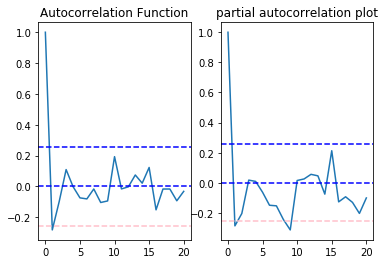

In [9]:
from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(ts_log_dif,nlags=20)
lag_pacf = pacf(ts_log_dif,nlags=20,method='ols')

######################### ACF ##########################################

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_dif)),linestyle='--',color='pink')
plt.axhline(y=1.96/np.sqrt(len(ts_log_dif)),linestyle='--',color='blue')
plt.title('Autocorrelation Function')

######################### PACF ##########################################

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_dif)),linestyle='--',color='pink')
plt.axhline(y=1.96/np.sqrt(len(ts_log_dif)),linestyle='--',color='blue')
plt.title('partial autocorrelation plot')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Program

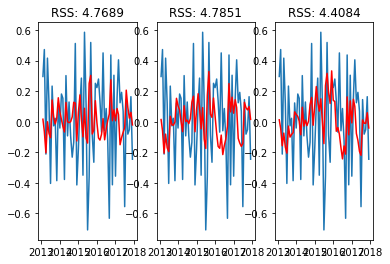

In [10]:
from statsmodels.tsa.arima_model import ARIMA

## AR
plt.subplot(131)
model = ARIMA(ts_log,order=(2,1,0))
result_AR = model.fit(disp=-1)
plt.plot(ts_log_dif)
plt.plot(result_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((result_AR.fittedvalues-ts_log_dif)**2))

## MA
plt.subplot(132)
model = ARIMA(ts_log,order=(0,1,2))
result_MA = model.fit(disp=-1)
plt.plot(ts_log_dif)
plt.plot(result_MA.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((result_MA.fittedvalues-ts_log_dif)**2))

## ARIMA
plt.subplot(133)
model = ARIMA(ts_log,order=(2,1,2))
result_MA = model.fit(disp=-1)
plt.plot(ts_log_dif)
plt.plot(result_MA.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((result_MA.fittedvalues-ts_log_dif)**2))
plt.show()

**Taking the prediction to original scale**

In [11]:
pred_arima_dif = pd.Series(result_MA.fittedvalues,copy=True)
arima_dif_cumsum = pred_arima_dif.cumsum()

pred_arima_log = pd.Series(ts_log.ix[0], index=ts_log.index)
pred_arima_log = pred_arima_log.add(arima_dif_cumsum,fill_value=0)
print(pred_arima_log.head())

pred = np.exp(pred_arima_log)

YearMonth
2013-01-01    2.037056
2013-02-01    2.049626
2013-03-01    2.005401
2013-04-01    1.848077
2013-05-01    1.773852
dtype: float64


**Actual vs predicted plot**

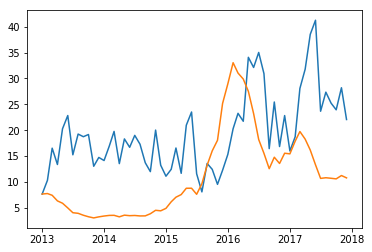

In [13]:
plt.plot(ts)
plt.plot(pred)
plt.show()